# Notebook para análisis y visualización de tokens

Este notebook permite graficar el total de tokens por año, por año y mes agrupados por canal, y un gráfico de líneas de tokens totales por mes-año.

## Importar librerías necesarias

Importamos pandas para manipulación de datos y matplotlib/seaborn para visualización.

In [15]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
load_dotenv()

True

In [17]:
login(token = os.environ.get("HF_TOKEN") )

dataset_name = "AndresR2909/youtube_transcriptions_summaries_2025_gpt4.1"

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [18]:
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
sel_columns = ["channel_name","video_id","publish_date","year","month","number_of_tokenks","duration"]
df_test = pd.read_parquet(f"hf://datasets/{dataset_name}/" + splits["test"], columns=sel_columns)
df_train = pd.read_parquet(f"hf://datasets/{dataset_name}/" + splits["train"], columns= sel_columns)

In [19]:
df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all.head()

,channel_name,video_id,publish_date,year,month,number_of_tokenks,duration
0,Bolsas hoy | Invierte y Crece,MEFcIWdwoEI,None,0,NaN,2389,822.0
1,Bolsas hoy | Invierte y Crece,yQdTS2296V8,None,0,NaN,3639,1251.0
2,Bolsas hoy | Invierte y Crece,5uDK19-gLkw,None,0,NaN,2847,907.0
3,Bolsas hoy | Invierte y Crece,dm-GKckZQG4,None,0,NaN,3380,1142.0
4,Bolsas hoy | Invierte y Crece,n4ZxNi2TjaY,None,0,NaN,3221,1055.0


## Cargar y preparar los datos

Nos aseguramos de que las columnas 'year', 'month' y 'number_of_tokenks' sean del tipo correcto y manejamos valores nulos.

In [20]:
# Convertir columnas a los tipos adecuados
df_all['year'] = pd.to_numeric(df_all['year'], errors='coerce').fillna(0).astype(int)
df_all['month'] = pd.to_numeric(df_all['month'], errors='coerce').fillna(0).astype(int)
df_all['number_of_tokenks'] = pd.to_numeric(df_all['number_of_tokenks'], errors='coerce')
df_all['duration'] = pd.to_numeric(df_all['duration'], errors='coerce')

# Opcional: eliminar filas sin información relevante de tokens
df_all = df_all.dropna(subset=['number_of_tokenks'])

## Graficar barras: total de tokens por año

Agrupamos el DataFrame por 'year' y sumamos 'number_of_tokenks'. Graficamos el resultado usando un gráfico de barras.

/var/folders/0z/3s22b27525jc3bm0m923h36h3wg489/T/ipykernel_60825/617987003.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tokens_por_anio, x='year', y='number_of_tokenks', palette='Blues_d')


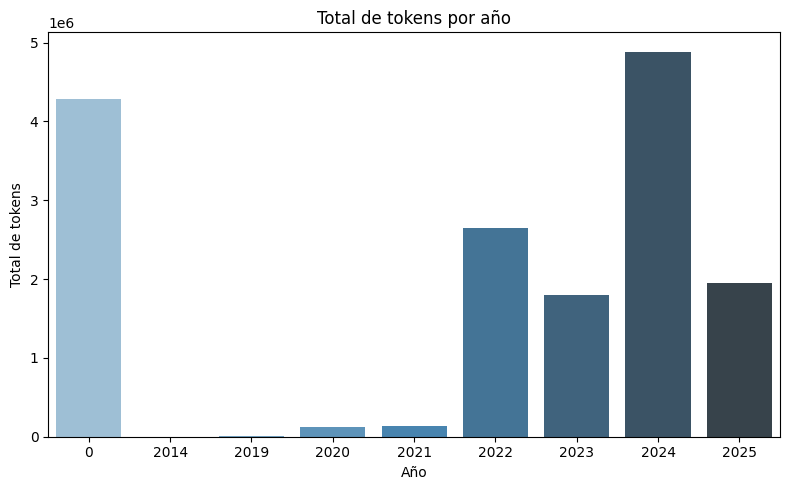

In [21]:
tokens_por_anio = df_all.groupby('year')['number_of_tokenks'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=tokens_por_anio, x='year', y='number_of_tokenks', palette='Blues_d')
plt.title('Total de tokens por año')
plt.xlabel('Año')
plt.ylabel('Total de tokens')
plt.tight_layout()
plt.show()

/var/folders/0z/3s22b27525jc3bm0m923h36h3wg489/T/ipykernel_60825/3132451980.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segundos_por_anio, x='year', y='duration', palette='Blues_d')


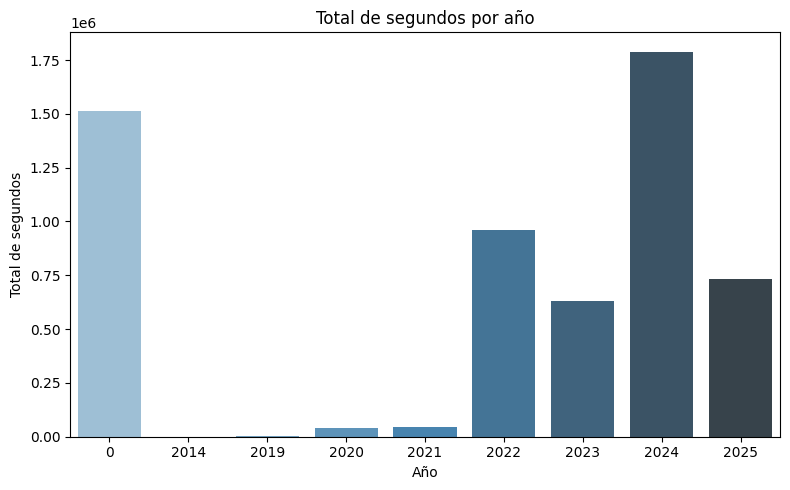

In [23]:
segundos_por_anio = df_all.groupby('year')['duration'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=segundos_por_anio, x='year', y='duration', palette='Blues_d')
plt.title('Total de segundos por año')
plt.xlabel('Año')
plt.ylabel('Total de segundos')
plt.tight_layout()
plt.show()

## Graficar barras: total de tokens por año y mes agrupados por canal

Agrupamos por 'channel_name', 'year' y 'month', sumamos 'number_of_tokenks' y graficamos con barras agrupadas.

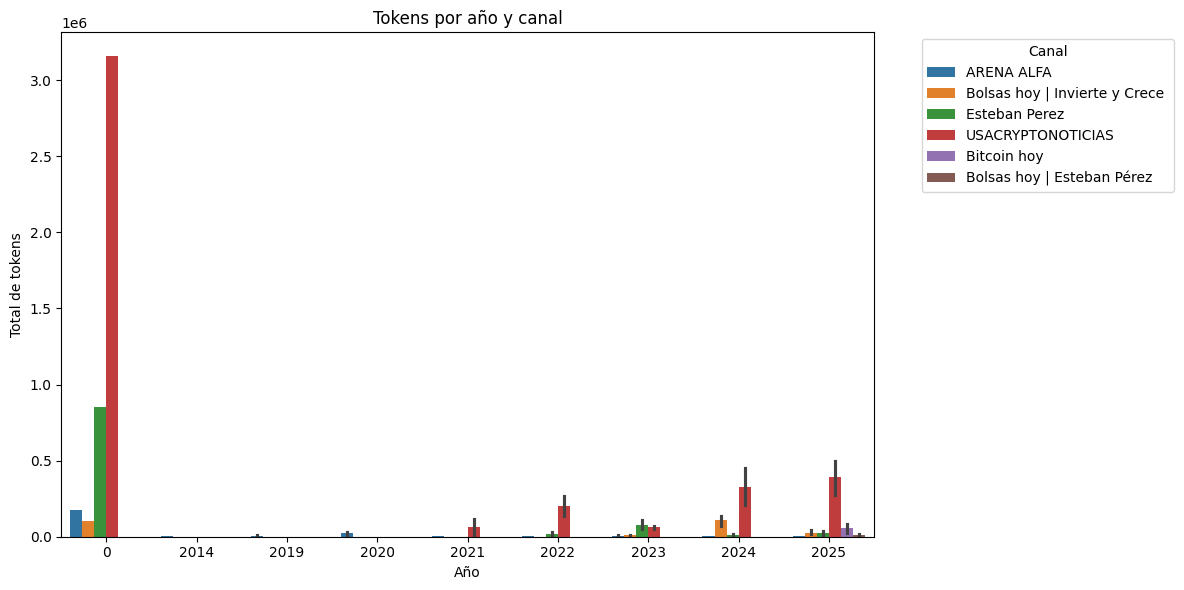

In [9]:
tokens_canal_anio_mes = (
    df_all.groupby(['channel_name', 'year', 'month'])['number_of_tokenks']
    .sum()
    .reset_index()
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=tokens_canal_anio_mes,
    x='year',
    y='number_of_tokenks',
    hue='channel_name'
)
plt.title('Tokens por año y canal')
plt.xlabel('Año')
plt.ylabel('Total de tokens')
plt.legend(title='Canal', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Crear columna mes-año

Creamos una columna combinando 'year' y 'month' en formato 'YYYY-MM' para usar en el eje x del gráfico de líneas.

In [24]:
df_all['mes_anio'] = df_all.apply(
    lambda row: f"{int(row['year']):04d}-{int(row['month']):02d}" if row['year'] > 0 and row['month'] > 0 else None,
    axis=1
)

## Graficar líneas: tokens totales por mes-año

Agrupamos por la nueva columna 'mes-año', sumamos 'number_of_tokenks' y graficamos una línea con el tiempo en el eje x y tokens en el eje y.

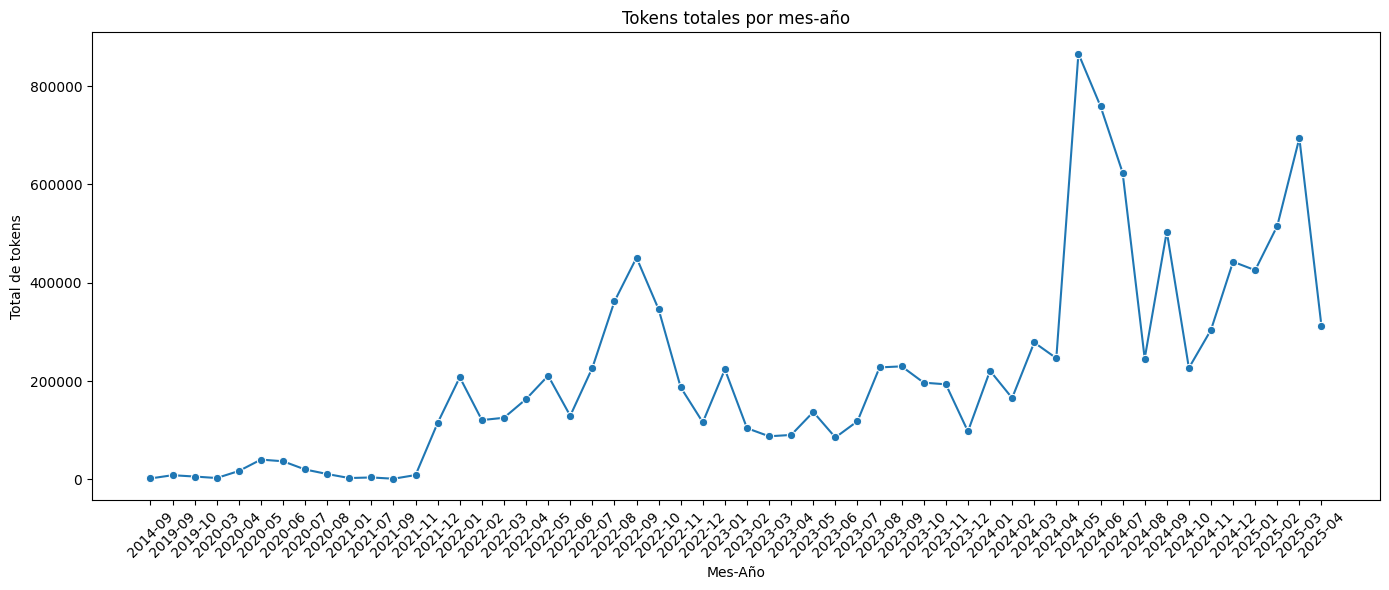

In [11]:
tokens_por_mes_anio = (
    df_all.dropna(subset=['mes_anio'])
    .groupby('mes_anio')['number_of_tokenks']
    .sum()
    .reset_index()
)

plt.figure(figsize=(14,6))
sns.lineplot(data=tokens_por_mes_anio, x='mes_anio', y='number_of_tokenks', marker='o')
plt.title('Tokens totales por mes-año')
plt.xlabel('Mes-Año')
plt.ylabel('Total de tokens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

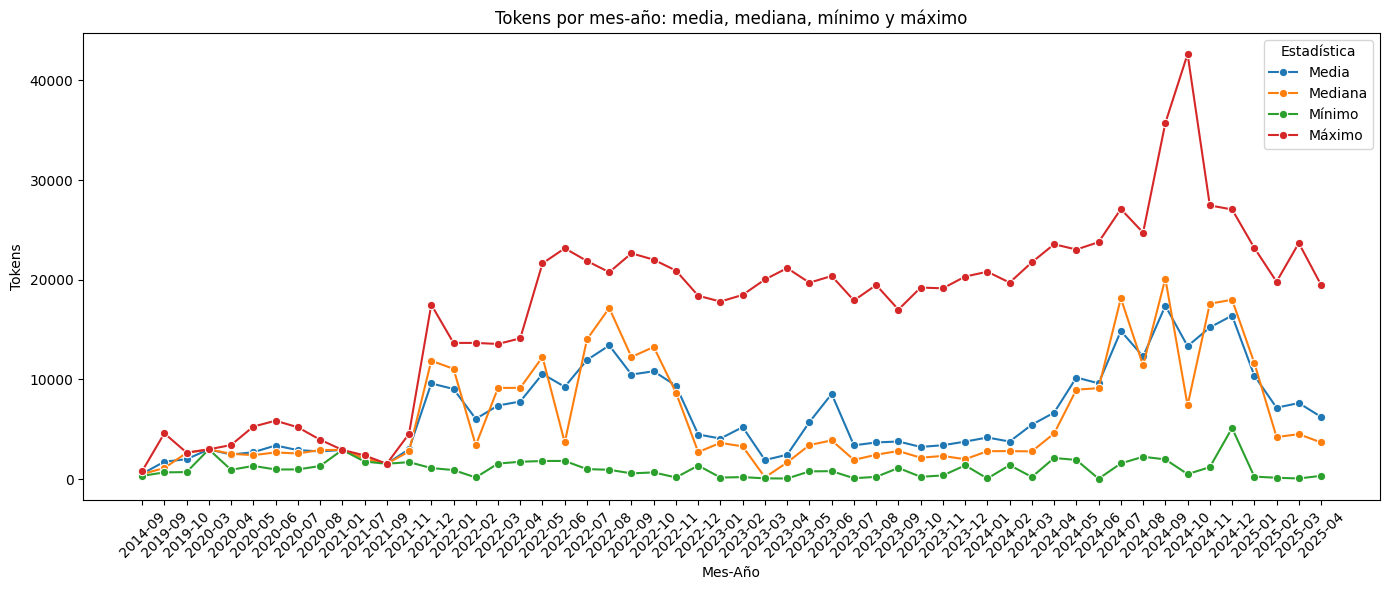

In [12]:
tokens_stats_mes_anio = (
    df_all.dropna(subset=['mes_anio'])
    .groupby('mes_anio')['number_of_tokenks']
    .agg(['mean', 'median', 'min', 'max'])
    .reset_index()
)

plt.figure(figsize=(14,6))
sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='mean', marker='o', label='Media')
sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='median', marker='o', label='Mediana')
sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='min', marker='o', label='Mínimo')
sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='max', marker='o', label='Máximo')
plt.title('Tokens por mes-año: media, mediana, mínimo y máximo')
plt.xlabel('Mes-Año')
plt.ylabel('Tokens')
plt.xticks(rotation=45)
plt.legend(title='Estadística')
plt.tight_layout()
plt.show()

In [13]:
df_all['channel_name'].unique()

array(['Bolsas hoy | Invierte y Crece ', 'USACRYPTONOTICIAS',
       'Esteban Perez ', 'ARENA ALFA ', 'Bitcoin hoy',
       'Bolsas hoy | Esteban Pérez'], dtype=object)

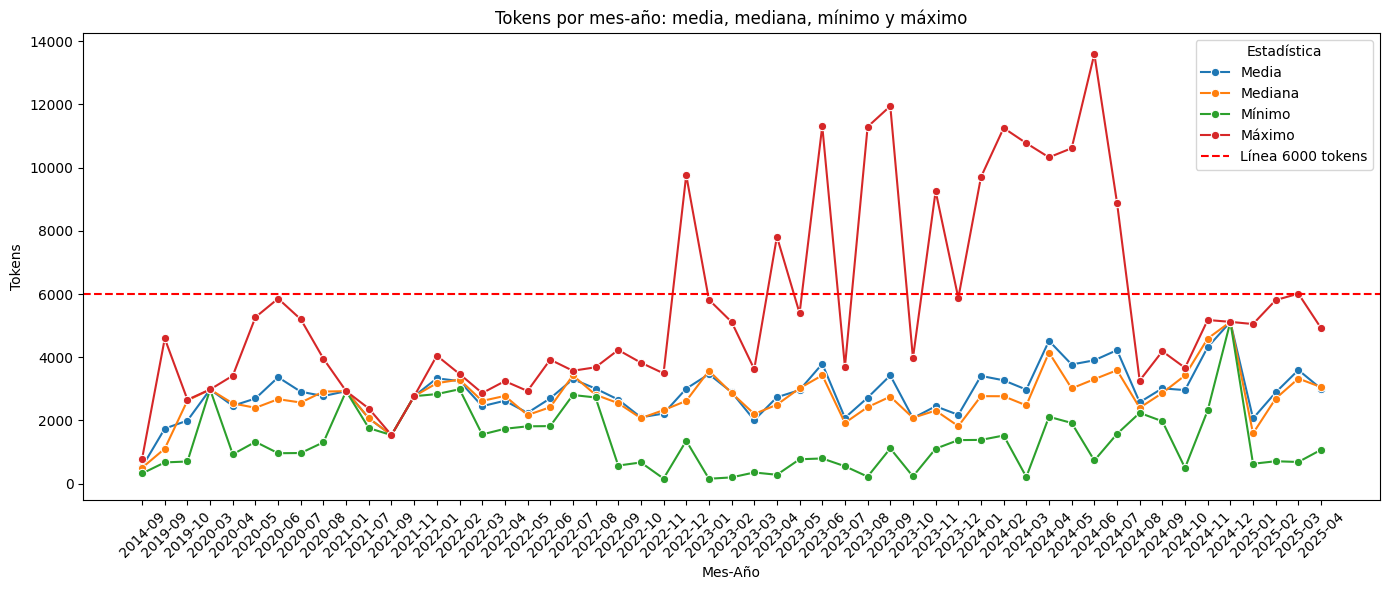

In [14]:
linea_tokens = 6000  # Puedes cambiar este valor para mover la línea

tokens_stats_mes_anio = (
    df_all[df_all['channel_name'] != 'USACRYPTONOTICIAS'].dropna(subset=['mes_anio'])
    .groupby('mes_anio')['number_of_tokenks']
    .agg(['mean', 'median', 'min', 'max'])
    .reset_index()
)

plt.figure(figsize=(14,6))
sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='mean', marker='o', label='Media')
sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='median', marker='o', label='Mediana')
sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='min', marker='o', label='Mínimo')
sns.lineplot(data=tokens_stats_mes_anio, x='mes_anio', y='max', marker='o', label='Máximo')
plt.axhline(linea_tokens, color='red', linestyle='--', label=f'Línea {linea_tokens} tokens')
plt.title('Tokens por mes-año: media, mediana, mínimo y máximo')
plt.xlabel('Mes-Año')
plt.ylabel('Tokens')
plt.xticks(rotation=45)
plt.legend(title='Estadística')
plt.tight_layout()
plt.show()

In [30]:
duration_stats_mes_anio = (
    df_all[df_all['channel_name'] != 'USACRYPTONOTICIAS'].dropna(subset=['mes_anio'])
    .groupby('mes_anio')['duration']
    .agg(['mean', 'median', 'min', 'max'])
    .reset_index()
)
duration_stats_mes_anio.describe()

,mean,median,min,max
count,53.000000,53.000000,53.000000,53.000000
mean,959.189292,914.047170,439.547170,1898.169811
std,292.064915,283.742626,348.017438,1100.541121
min,162.500000,154.500000,0.000000,241.000000
25%,764.954545,781.500000,221.000000,1174.000000
50%,934.127273,885.500000,401.000000,1563.000000
75%,1126.000000,1030.000000,604.000000,2106.000000
max,1907.000000,1907.000000,1907.000000,4672.000000


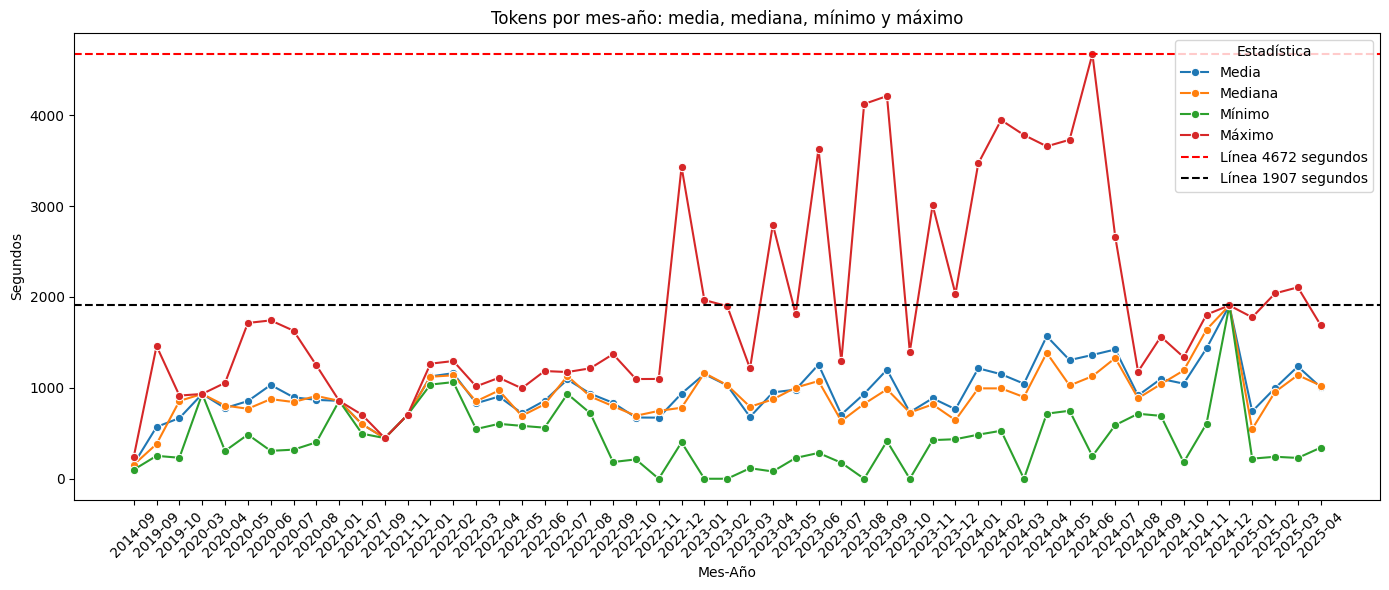

In [35]:
linea_segundos = 4672  # Puedes cambiar este valor para mover la línea



plt.figure(figsize=(14,6))
sns.lineplot(data=duration_stats_mes_anio, x='mes_anio', y='mean', marker='o', label='Media')
sns.lineplot(data=duration_stats_mes_anio, x='mes_anio', y='median', marker='o', label='Mediana')
sns.lineplot(data=duration_stats_mes_anio, x='mes_anio', y='min', marker='o', label='Mínimo')
sns.lineplot(data=duration_stats_mes_anio, x='mes_anio', y='max', marker='o', label='Máximo')
plt.axhline(linea_segundos, color='red', linestyle='--', label=f'Línea {linea_segundos} segundos')
plt.axhline(1907, color='black', linestyle='--', label=f'Línea {1907} segundos')
plt.title('Tokens por mes-año: media, mediana, mínimo y máximo')
plt.xlabel('Mes-Año')
plt.ylabel('Segundos')
plt.xticks(rotation=45)
plt.legend(title='Estadística')
plt.tight_layout()
plt.show()